In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generar_particiones(filename, n, p_test):
    ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx=np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (ds, M_test, M_train)


# Ejercicio 3

Implemente el algoritmo de retropropagación para un perceptrón multicapa de forma que se puedan elegir libremente las cantidades de capas de la red y de neuronas en cada capa.

In [4]:
def sigmoidea(x):
    return np.divide(2, (1 + np.exp(-x))) - 1

In [5]:
class layer:
    def __init__(self, n_neuron, n_x):
        self.n_neuron = n_neuron
        self.n_entradas = n_x
        self.w = np.random.normal(loc = 0, scale = 0.15, size =(n_neuron,n_x))
        
    def calculate_y(self,x):
        y = np.dot(self.w,x)
        #print(y)
        y = sigmoidea(y)
        return y   


In [6]:
def perceptron_multilayer_init(neurons_perLayer, n_x):
    network=[]
    aux_n_x = n_x
    for i in range(neurons_perLayer.shape[0]):
        network.append(layer(neurons_perLayer[i], aux_n_x + 1))
        aux_n_x = neurons_perLayer[i]
    return(network)

In [7]:
def perceptron_multilayer_forward(network,x):
    # completa la primera capa
    y=[x]
    for i in range(len(network)):
        # print(np.hstack((-1, y[i])))
        y.append( \
                network[i].calculate_y( \
                    np.hstack((-1, y[i]))\
                        )\
        )
        # print(y)
    return y

In [8]:
def perceptron_multilayer_backward(network,y,yd):
    # e=np.sum(((yd-y[-1])**2))
    e=yd-y[-1]
    grad=[]
    grad.append(np.multiply(np.multiply(e,np.multiply(np.add(1, y[-1]),np.subtract(1, y[-1]))), 0.5))
    for i in range(len(network)-1,0,-1):
        w_t=network[i].w[:,1:].T
        #print(f'pesos sin la fila de w0 y transpuesto = {w_t}')
        g = np.multiply(np.multiply(np.dot(w_t,grad[len(network)-1-i]),np.multiply(np.add(1, y[i]),np.subtract(1, y[i]))), 0.5)
        grad.append(g)
    return grad


# def perceptron_multilayer_backward(network,y,yd):
#     # e=np.sum(((yd-y[-1])**2))
#     e=yd-y[-1]
#     grad=[]
#     grad.append(np.multiply(e,np.multiply((1+y[-1]),(1-y[-1])))*0.5)
#     for i in range(len(network)-1,0,-1):
#         w_t=network[i].w[:,1:].T
#         #print(f'pesos sin la fila de w0 y transpuesto = {w_t}')
#         grad.append(np.multiply(np.dot(w_t,grad[len(network)-1-i]),np.multiply((1+y[i]),(1-y[i])))*0.5)
#     return grad


In [9]:
def perceptron_multilayer_update(network,y,grad,gamma):
    for i in range(len(network)):
        w_new = gamma * np.outer(grad[-(i+1)],np.hstack((-1, y[i])))
        network[i].w += w_new
        # print(i,network[i].w)
    return network 

## Problema XOR
### Train

In [10]:
ds, M_tst, M_trn  =  generar_particiones('icgtp1datos\XOR_trn.csv', 1, 0.2)
X = ds[M_trn[0,:], :-1]
#X_a = np.array([[-1.0291,0.97256],[1.0325,-1.0188]])

# print(X)
Y_d = ds[M_trn[0,:], -1]
#Y_d = [1, 1]
# print(Y_d)
network = []
# X = np.hstack((-1, np.ones((X.shape[0],1)), X))
n_per_layer = np.array([2, 1])
network = perceptron_multilayer_init(n_per_layer, X.shape[1])
#print(f'pesos capa 1{network[0].w}')
#print(f'pesos capa 2{network[1].w}')

cant_epocas = 60
nu_error = 0.01
error_epocas = []
gamma_aprend = 0.01
mse_epocas = []

for n_epoch in range(cant_epocas):
    for i, pattern in enumerate(X):
        #print('patron:', pattern)
        y = perceptron_multilayer_forward(network, pattern)
        #print(f'salida{i}={y}')
        grad = perceptron_multilayer_backward(network, y, Y_d[i])
        #print(f'gradiente = {grad}')
        network = perceptron_multilayer_update(network, y, grad, gamma_aprend)
    
    # Validación [con todos los patrones]
    errores = 0
    mse_epoca=np.array([])
    for n, patron in enumerate(X):
        # producto punto
        y_test = perceptron_multilayer_forward(network, patron)
        # estamos suponiendo una sola salida
        #y = -1 if (y_test[-1] < 0) else 1
        y_aux=0
        if (y_test[-1] < 0):
            y_aux=-1
        else:
            y_aux=1
        # print('y',y,'yDeseada',Y_d[n])
        errores += int(y_aux != Y_d[n])
        # print('errores', errores)}

        #cálculo del error cuadrático medio
        mse = np.sum(pow(np.subtract(y_test[-1], Y_d[n]), 2))
        
        # print(mse)
        mse_epoca = np.append(mse_epoca, mse)

    error = (errores/X.shape[0])
        # error = np.sum(((y[-1]-Y_d[i])**2))        
    error_epocas= np.append(error_epocas, [error])
    
    e_prom = np.mean(mse_epoca)
    mse_epocas = np.append(mse_epocas, e_prom)

    # print(f'Epoca {n_epoch}: error = {error}')
    if (error < nu_error):
        # print(f'Época {n_epoch}')
        break
   
print(f'Epoca {n_epoch}: error = {error_epocas[-1]}')

Epoca 24: error = 0.0


### Test

In [11]:
X_test = ds[M_tst[0,:], :-1]
Y_d_test = ds[M_tst[0,:], -1]
errores = 0

for i, pattern in enumerate(X_test):
    y_test = perceptron_multilayer_forward(network, pattern)
    # estamos suponiendo una sola salida
    y = -1 if (y_test[-1] < 0) else 1
    errores += int(y != Y_d_test[i])

print(f'accuracy de prueba {errores / X_test.shape[0]}')



accuracy de prueba 0.0


### Plot

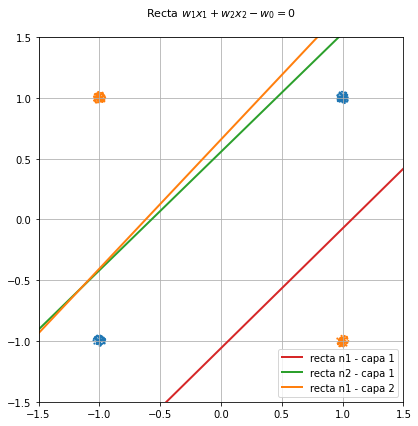

In [12]:
# pesos primer neurona
w1 = network[0].w[0]

# pesos segunda neurona
w2 = network[0].w[1]

# pesos neurona capa 2
w21 = network[1].w[0]

fig1 = plt.figure(figsize=(7, 6), tight_layout=True)
fig1.suptitle('Recta $w_1 x_1 + w_2 x_2 - w_0 = 0$',  fontsize=11)
fig1_ax = fig1.add_subplot(autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
fig1_ax.set_aspect('equal')
fig1_ax.grid()

# Patrones
x_x = X_test[:,0]
x_y = X_test[:,1]
x_color = np.where(x_x > 0, np.where(x_y > 0, 'C0', 'C1'), np.where(x_y < 0, 'C0', 'C1'))
fig1_ax.scatter(x_x, x_y, c=x_color, s=5, marker='.')

# Recta
xx = np.arange(-3, 3, 0.01)
a1 = w1[0] / w1[2]
b1 = w1[1] / w1[2]
fig1_ax.plot(xx, a1 - b1 * xx, c='C3', linewidth=2, label = 'recta n1 - capa 1')

a2 = w2[0] / w2[2]
b2 = w2[1] / w2[2]
fig1_ax.plot(xx, a2 - b2 * xx, c='C2', linewidth=2, label = 'recta n2 - capa 1')

a3 = w21[0] / w21[2]
b3 = w21[1] / w21[2]
fig1_ax.plot(xx, a3 - b3 * xx, c='C1', linewidth=2,label = 'recta n1 - capa 2')

fig1_ax.legend(loc = 4)
plt.show()
